In [ ]:
#default_exp poi.utils

In [ ]:
from speechsep.imports import *
from speechsep.data import *
from speechsep.core import *
from speechsep.masks import *
from speechsep.utils import *

/home/cerberus/.anaconda3/envs/fai2/lib/python3.7/site-packages/fastcore/basics.py:790: UserWarning: `patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead
  warnings.warn("`patch_property` is deprecated and will be removed; use `patch(as_prop=True)` instead")


In [ ]:
from speechsep.base import *

# Utils

In [ ]:
def files2mask(files):
    tfms = [AudioMono.create, Resample(22050), Clip(5)]
    audios = [compose_tfms(f, tfms) for f in files]
    aud2mask = Maskify()
    mixed_spec, masks = aud2mask(audios)
    return [mixed_spec, masks[0]]

In [ ]:
class POIMesher:
    def __init__(self, poi):
        self.poi = poi

    def get_poi_files(self, path):
        return get_audio_files(path, folders=f"{self.poi}")

    def get_non_poi_files(self, path):
        files = get_audio_files(path)
        poi_path = path/str(self.poi)
        return [file for file in files if poi_path not in list(file.parents)]

    def __call__(self, path):
        rand_poi = []
        poi_files = self.get_poi_files(path)
        non_poi_files = self.get_non_poi_files(path)
        for x in range(len(non_poi_files)):
            rand_poi.append(random.choice(poi_files))
        return list(map(list,zip(rand_poi, non_poi_files)))

# Dataset

In [ ]:
class SpecMaskDataset(torch.utils.data.Dataset):
    def __init__(self, path, poi):
        self.files = POIMesher(poi)(path)
        self.tensorify = ToTensor()
        
    def __getitem__(self, i):
        spec, mask = files2mask(self.files[i])
        return self.tensorify(spec), self.tensorify(mask)
    
    def __len__(self): return len(self.files)

In [ ]:
fn = Path("/home/cerberus/Music/LibriSpeech/test-clean/")

train_ds = SpecMaskDataset(fn, "6829")

dls = DataLoaders.from_dsets(train_ds, train_ds)

# Data Explore and verify

In [ ]:
AudioMono.create(dls.files[0][0])

/home/cerberus/Music/LibriSpeech/test-clean/6829/68769/6829-68769-0051.flac, 3.5450340136054423secs at 22050 samples per second

In [ ]:
AudioMono.create(dls.files[0][1])

/home/cerberus/Music/LibriSpeech/test-clean/1580/141084/1580-141084-0014.flac, 3.9700226757369617secs at 22050 samples per second

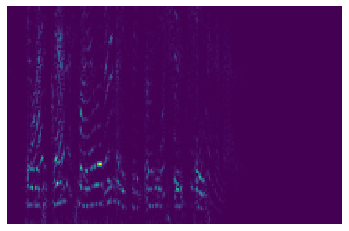

In [ ]:
dls.dataset[0][0].show()

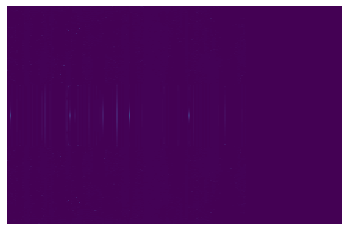

In [ ]:
dls.dataset[0][1].show()

# Listen to inputs

In [ ]:
def listen2spec(spec):
    cplx_spec = real2complex(spec)
    specbase = SpecBase(cplx_spec, 22050)

    return Spectify().decode(specbase)

In [ ]:
def createMask(mask):
    return MaskBinary(mask.numpy())

In [ ]:
listen2spec(dls.dataset[0][0])

None, 4.992290249433107secs at 22050 samples per second

In [ ]:
mask = MaskBinary(dls.dataset[0][1].numpy())

In [ ]:
listen2spec(dls.dataset[0][0]*mask)

None, 4.992290249433107secs at 22050 samples per second